## Brain Tumor Detection Using a Convolutional Neural Network

# importing libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [3]:
def crop_brain_contour(image, plot=False):
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

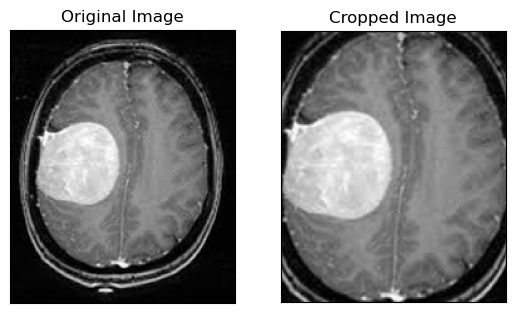

In [4]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
        
            image = cv2.imread(directory + '\\' + filename)
          
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
augmented_path = 'augmented data/'

augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [7]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

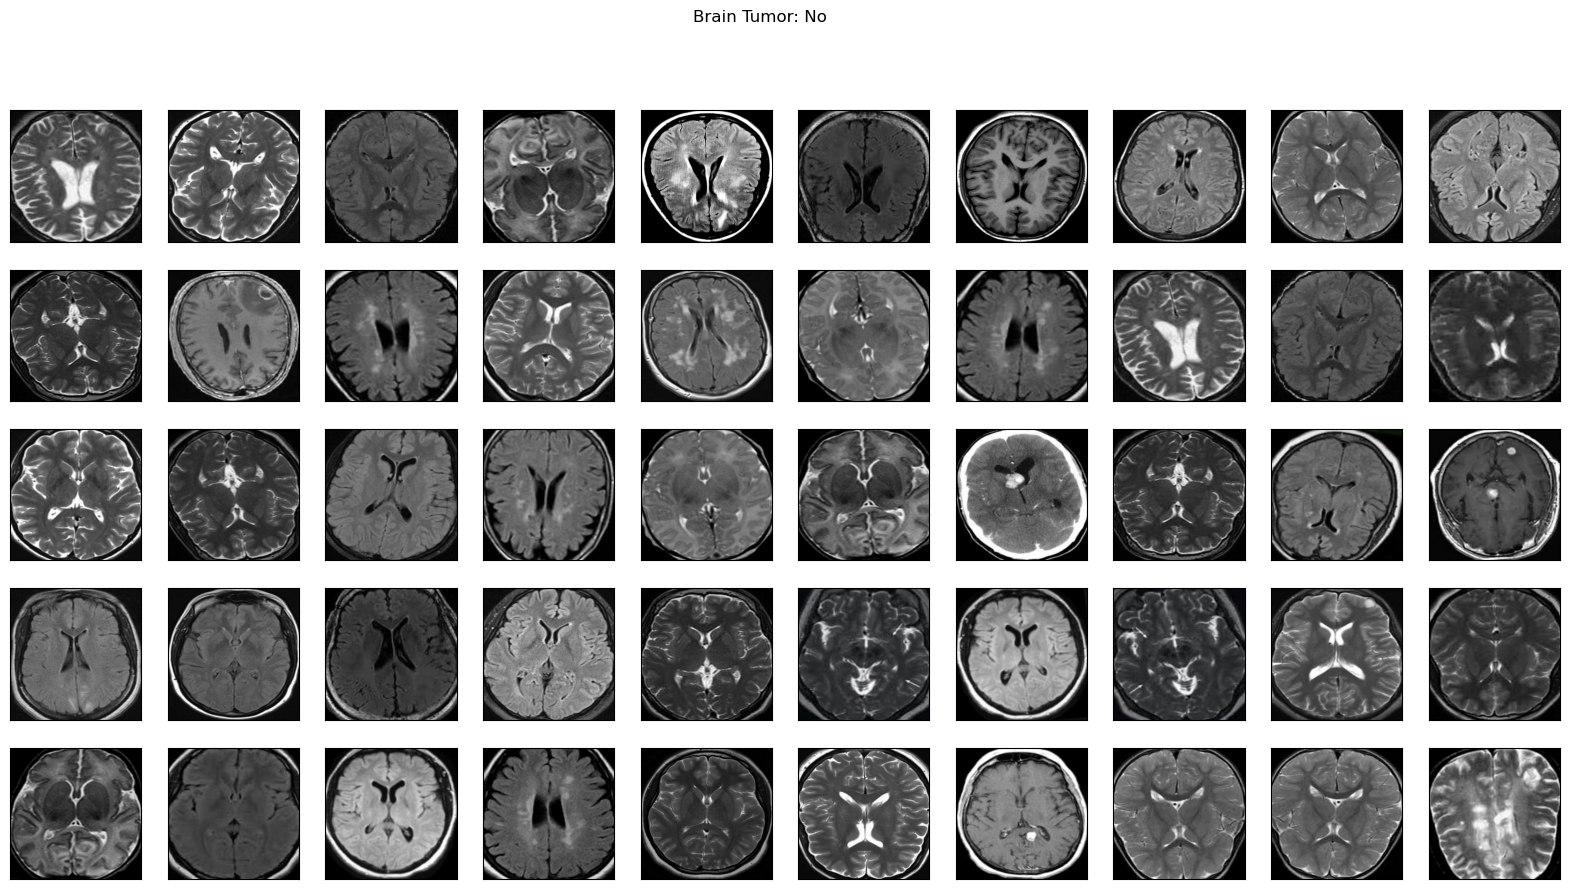

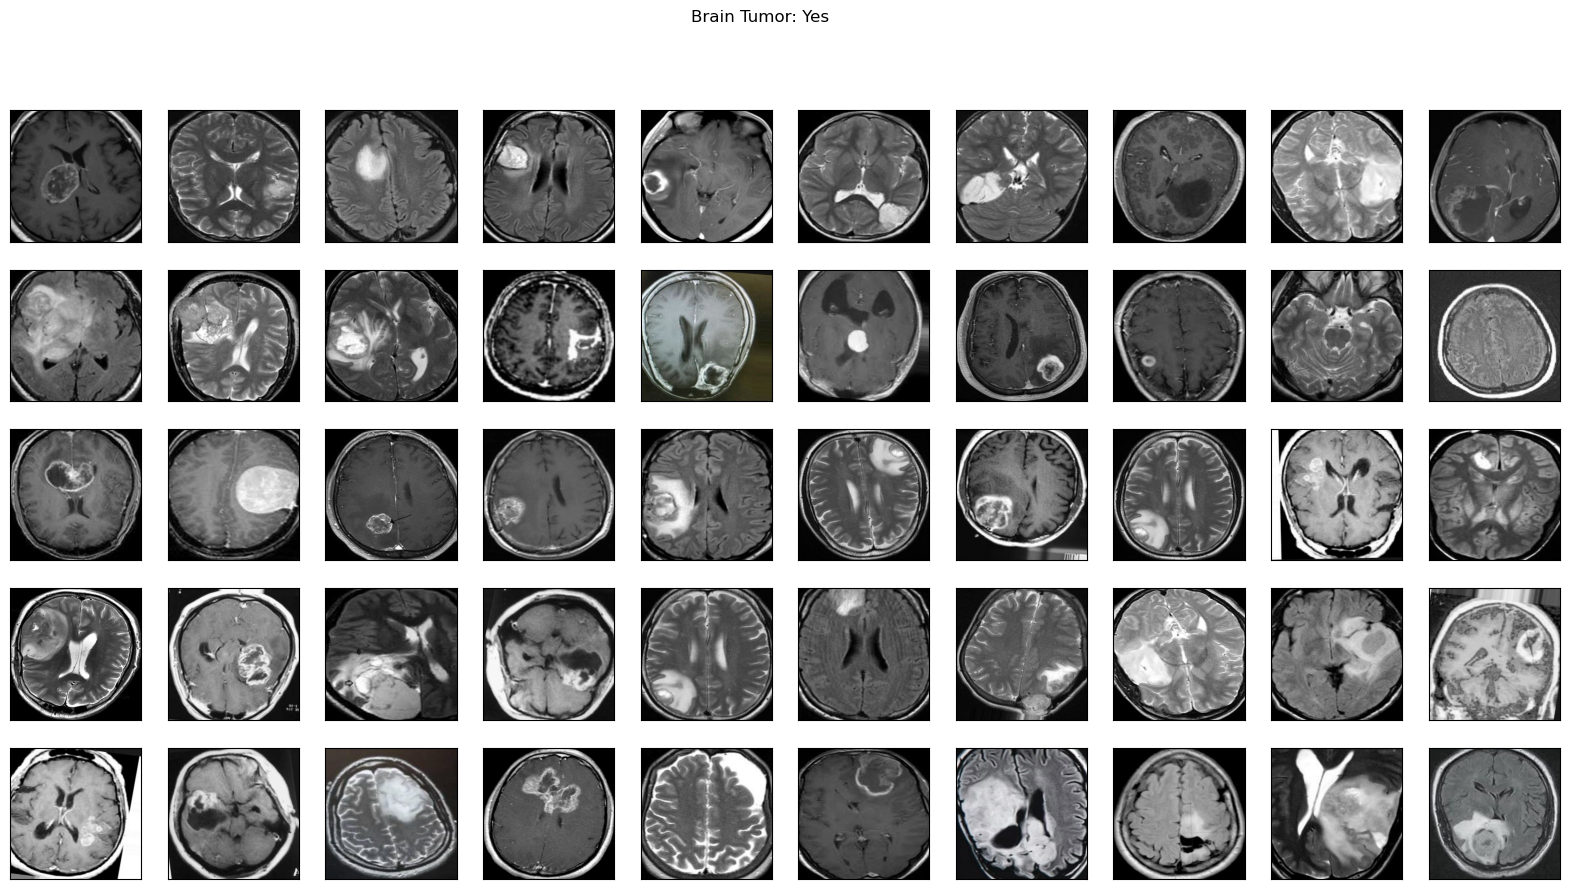

In [8]:
plot_sample_images(X, y)

In [9]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [12]:

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def compute_f1_score(y_true, prob):
    
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

<img src='convnet_architecture.jpg'>

In [14]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    
    X_input = Input(input_shape) 
    
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4), name='max_pool0')(X) 
    
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid', name='fc')(X) 
    
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [15]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [16]:
model = build_model(IMG_SHAPE)

In [17]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 244, 244, 3)       0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [20]:

filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [21]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.9071 - accuracy: 0.5917INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.52.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.52.model\assets


46/46 [==============================] - 62s 1s/step - loss: 0.9071 - accuracy: 0.5917 - val_loss: 0.6770 - val_accuracy: 0.5226
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.7702INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.62.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.62.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.4797 - accuracy: 0.7702 - val_loss: 0.6255 - val_accuracy: 0.6161
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 0.4223 - accuracy: 0.8028INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.78.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.78.model\assets


46/46 [==============================] - 62s 1s/step - loss: 0.4223 - accuracy: 0.8028 - val_loss: 0.5696 - val_accuracy: 0.7774
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8484INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.83.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.83.model\assets


46/46 [==============================] - 59s 1s/step - loss: 0.3561 - accuracy: 0.8484 - val_loss: 0.5200 - val_accuracy: 0.8290
Epoch 5/10
46/46 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.8498INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.81.model\assets


46/46 [==============================] - 59s 1s/step - loss: 0.3507 - accuracy: 0.8498 - val_loss: 0.4779 - val_accuracy: 0.8065
Epoch 6/10
46/46 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.8934INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.84.model\assets


46/46 [==============================] - 72s 2s/step - loss: 0.2777 - accuracy: 0.8934 - val_loss: 0.4261 - val_accuracy: 0.8419
Epoch 7/10
46/46 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.8401INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.77.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.77.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.3550 - accuracy: 0.8401 - val_loss: 0.4502 - val_accuracy: 0.7742
Epoch 8/10
46/46 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8830INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.75.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.75.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.2881 - accuracy: 0.8830 - val_loss: 0.4862 - val_accuracy: 0.7452
Epoch 9/10
46/46 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9149INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.85.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.85.model\assets


46/46 [==============================] - 59s 1s/step - loss: 0.2218 - accuracy: 0.9149 - val_loss: 0.3438 - val_accuracy: 0.8516
Epoch 10/10
46/46 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.9031INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.80.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.80.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.2378 - accuracy: 0.9031 - val_loss: 0.3966 - val_accuracy: 0.8032
Elapsed time: 0:10:6.2


In [22]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9080INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.87.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.2265 - accuracy: 0.9080 - val_loss: 0.3101 - val_accuracy: 0.8677
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9176INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.85.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.85.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.2010 - accuracy: 0.9176 - val_loss: 0.3326 - val_accuracy: 0.8452
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9426INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.83.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.83.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.1742 - accuracy: 0.9426 - val_loss: 0.4087 - val_accuracy: 0.8258
Elapsed time: 0:2:56.6


In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9426INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


46/46 [==============================] - 60s 1s/step - loss: 0.1605 - accuracy: 0.9426 - val_loss: 0.2760 - val_accuracy: 0.8839
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.9550INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.1405 - accuracy: 0.9550 - val_loss: 0.3038 - val_accuracy: 0.8806
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9467INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.80.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.80.model\assets


46/46 [==============================] - 55s 1s/step - loss: 0.1472 - accuracy: 0.9467 - val_loss: 0.5014 - val_accuracy: 0.7968
Elapsed time: 0:2:53.7


In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.9529INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.85.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.85.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.1476 - accuracy: 0.9529 - val_loss: 0.3500 - val_accuracy: 0.8484
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9190INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.87.model\assets


46/46 [==============================] - 60s 1s/step - loss: 0.1828 - accuracy: 0.9190 - val_loss: 0.2975 - val_accuracy: 0.8710
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9682INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.87.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.1089 - accuracy: 0.9682 - val_loss: 0.3045 - val_accuracy: 0.8742
Elapsed time: 0:2:57.5


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9696INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


46/46 [==============================] - 59s 1s/step - loss: 0.1054 - accuracy: 0.9696 - val_loss: 0.2856 - val_accuracy: 0.8806
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9716INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets


46/46 [==============================] - 61s 1s/step - loss: 0.0928 - accuracy: 0.9716 - val_loss: 0.2855 - val_accuracy: 0.8806
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9841INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.84.model\assets


46/46 [==============================] - 59s 1s/step - loss: 0.0812 - accuracy: 0.9841 - val_loss: 0.3843 - val_accuracy: 0.8387
Epoch 4/5
46/46 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9758INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.90.model\assets


46/46 [==============================] - 64s 1s/step - loss: 0.0912 - accuracy: 0.9758 - val_loss: 0.2477 - val_accuracy: 0.9000
Epoch 5/5
46/46 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9751INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.85.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.85.model\assets


46/46 [==============================] - 53s 1s/step - loss: 0.0949 - accuracy: 0.9751 - val_loss: 0.3575 - val_accuracy: 0.8484
Elapsed time: 0:4:56.8


In [26]:
history = model.history.history

In [27]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [28]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_accuracy = history['val_accuracy']
    
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

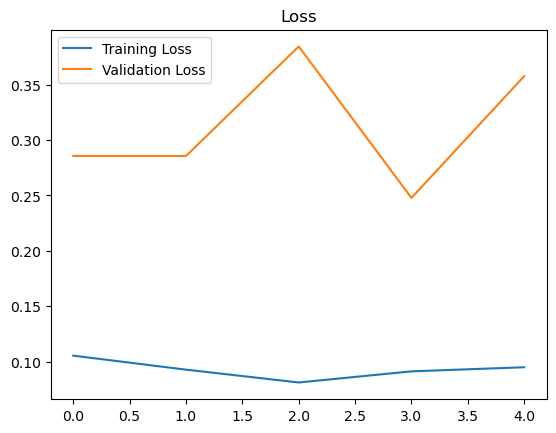

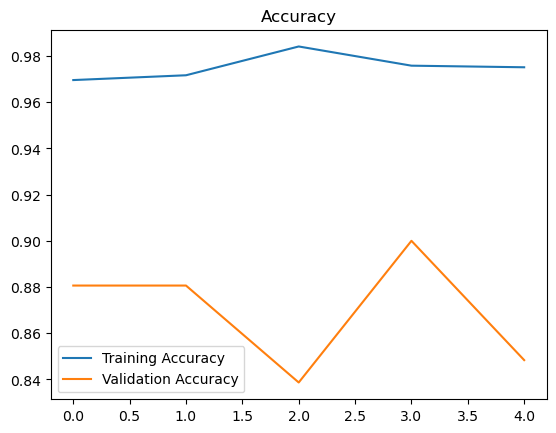

In [29]:
plot_metrics(history) 

In [30]:
pip install visualkeras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Results

In [ ]:
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

In [ ]:
best_model.metrics_names

Evaluate the best model on the testing data:

In [ ]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

### Accuracy of the best model on the testing data:

In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

### F1 score for the best model on the testing data:

In [ ]:
y_test_prob = best_model.predict(X_test)

In [ ]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

Let's also find the f1 score on the validation data:

In [ ]:
y_val_prob = best_model.predict(X_val)

In [ ]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [ ]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [ ]:
# the whole data
data_percentage(y)

In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

# Conclusion:

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 94%            | 97%      |
| F1 score  | 0.96           | 0.97     |